In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve


###Data Exploration

In [ ]:
paypal_data = pd.read_csv('/content/drive/MyDrive/Case Studies/PayPal/datasets/paypal_data.csv')

In [ ]:
df = paypal_data.copy()
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
df.shape

(1000000, 8)

1 million records across 7 features & 1 target

In [ ]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Numerical features:
* distance_from_home
* distance_from_last_transaction
* ratio_to_median_purchase_price

Categorical Features:
* repeat_retailer (1= 'yes' , 0= 'no')
* used_chip (1= 'yes' , 0= 'no')
* used_pin_number (1= 'yes' , 0= 'no')
* online_order (1= 'yes' , 0= 'no')

Target:
* fraud (1= 'yes' , 0= 'no')

In [ ]:
df['fraud'].value_counts()

,count
fraud,
0.0,912597
1.0,87403


Majority of the transactions are labelld as non-fraudulent.

In [ ]:
#Check the distribution of categories for all other categorical columns
for col in df.columns:
  if col in ['repeat_retailer','used_chip','used_pin_number','online_order']:
    print(df[col].value_counts())
    print("\n")

repeat_retailer
1.0    881536
0.0    118464
Name: count, dtype: int64


used_chip
0.0    649601
1.0    350399
Name: count, dtype: int64


used_pin_number
0.0    899392
1.0    100608
Name: count, dtype: int64


online_order
1.0    650552
0.0    349448
Name: count, dtype: int64




In [ ]:
df['fraud'].mean()

np.float64(0.087403)

Rate of Fraud = 8.7%

###EDA

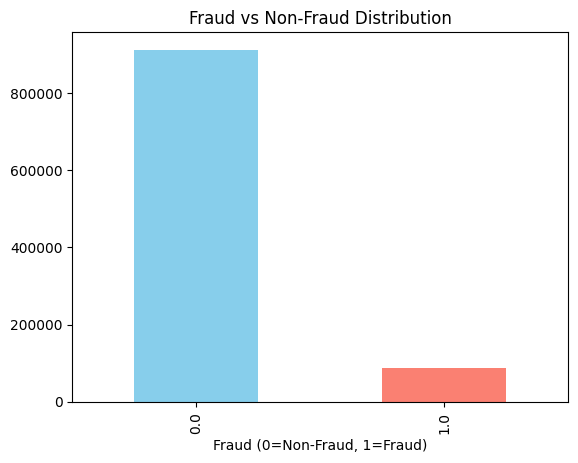

In [ ]:
#Plot Fraud Distribution
df['fraud'].value_counts().plot(kind='bar',color=['skyblue','salmon'])
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud (0=Non-Fraud, 1=Fraud)')
plt.show()

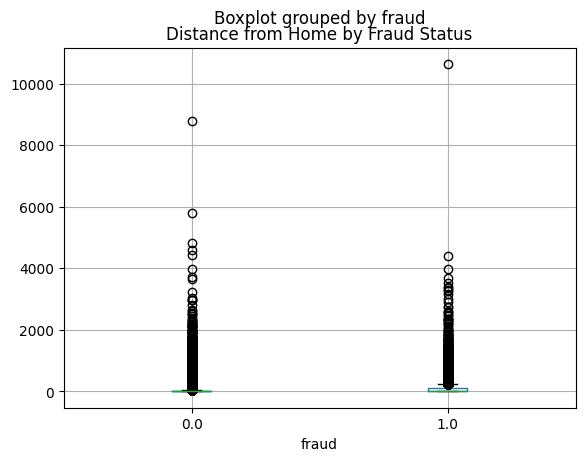

In [ ]:
#Distance from home by fraud
df.boxplot(column='distance_from_home',by='fraud')
plt.title('Distance from Home by Fraud Status')
plt.grid(True)
plt.show()

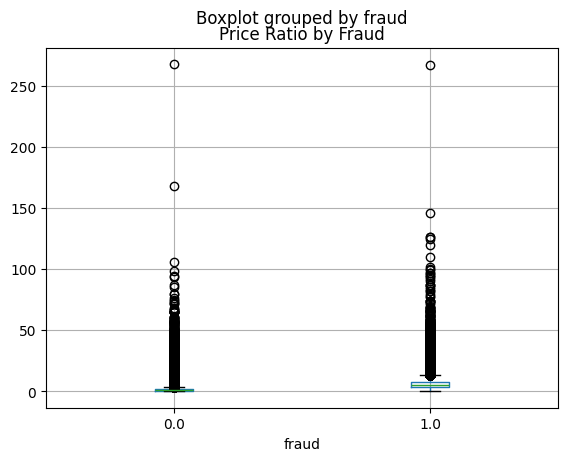

In [ ]:
#Price Ratio by fraud
df.boxplot(column='ratio_to_median_purchase_price',by='fraud')
plt.title('Price Ratio by Fraud')
plt.grid(True)
plt.show()

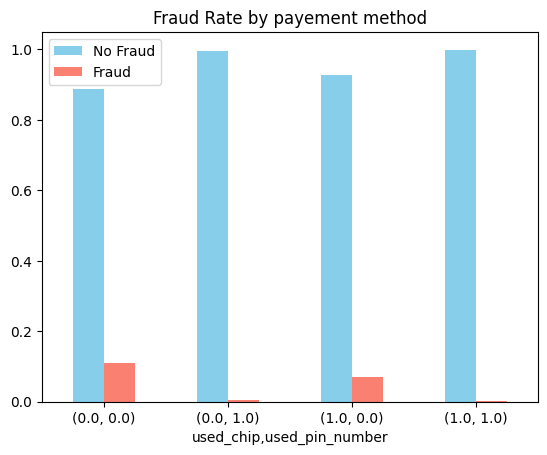

In [ ]:
#Transaction method analysis
method_fraud = pd.crosstab([df['used_chip'],df['used_pin_number']],df['fraud'],normalize='index')
method_fraud.plot(kind='bar',color=['skyblue','salmon'])
plt.title('Fraud Rate by payement method')
plt.xticks(rotation=0)
plt.legend(['No Fraud','Fraud'])

Fraud cases mostly occur when:
* No chip used , no pin number used
* chip is used, but pin number is not used

Fraud cases tend to lower when:
* chip is not used, pin number is used
* both chip and pin numbers are not used

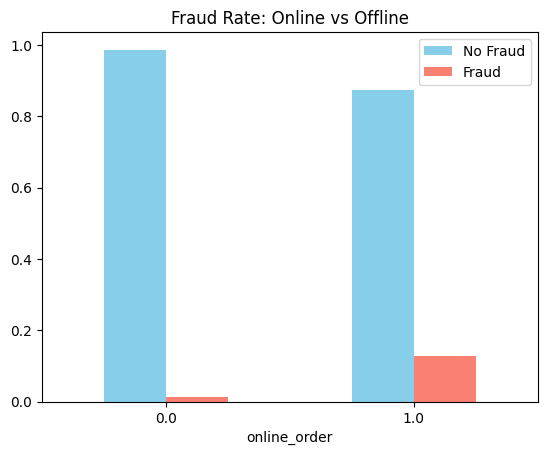

In [ ]:
#Online vs Offline
online_fraud = pd.crosstab(df['online_order'],df['fraud'],normalize='index')
online_fraud.plot(kind='bar',color=['skyblue','salmon'])
plt.title('Fraud Rate: Online vs Offline')
plt.xticks(rotation=0)
plt.legend(['No Fraud', 'Fraud'])
plt.show()

Online transactions show more instances of being fraud

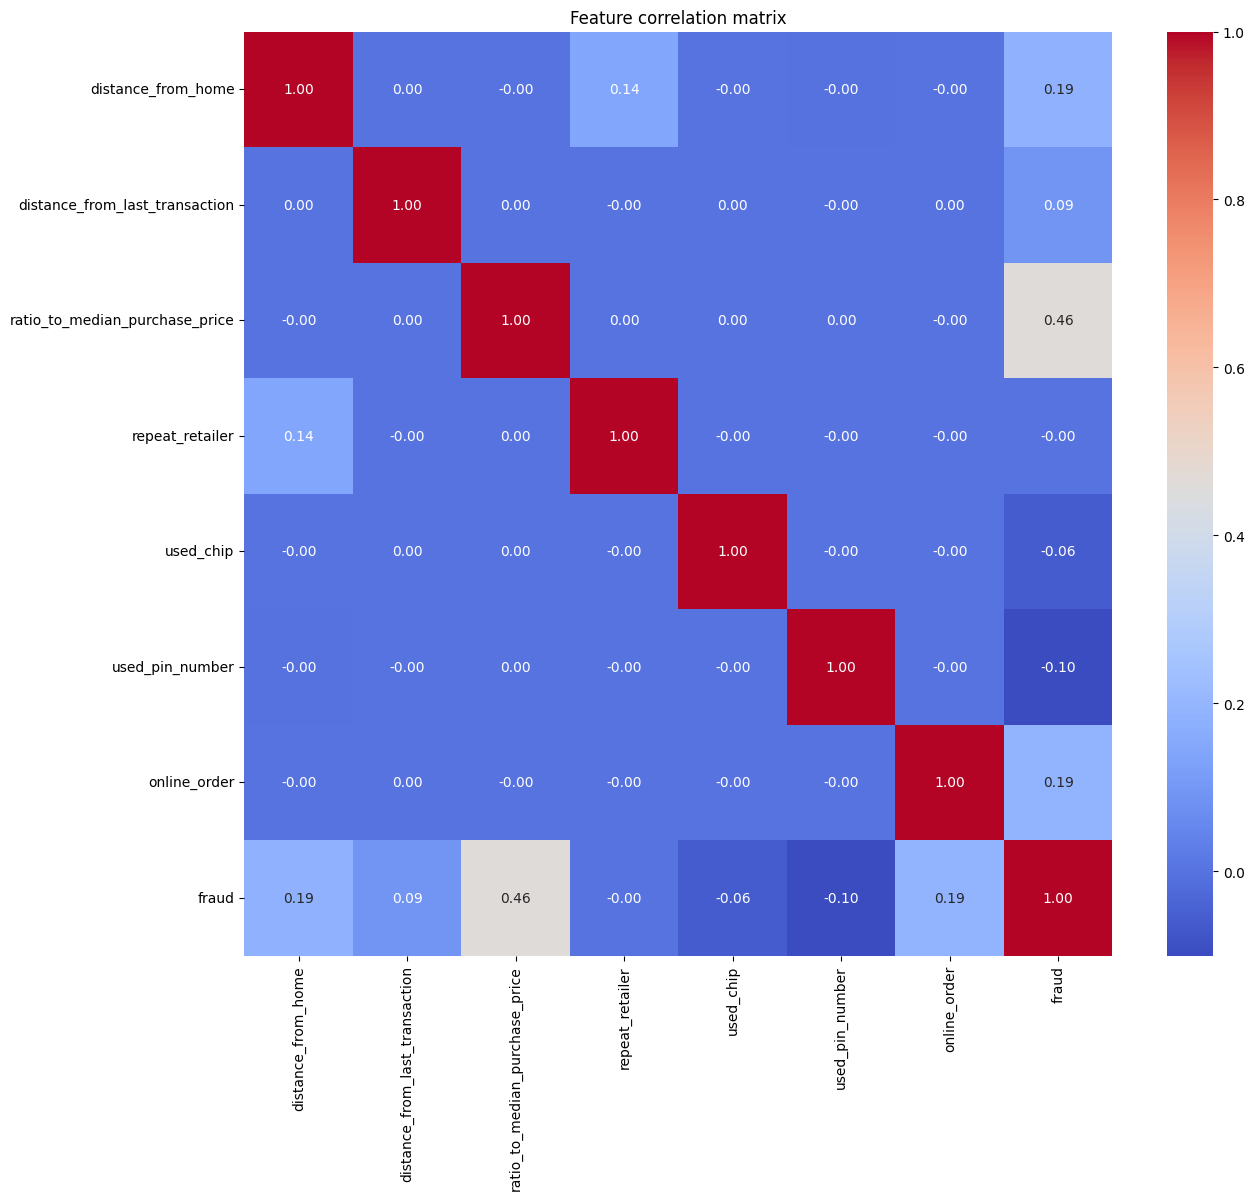

In [ ]:
#Correlation heatmap
plt.figure(figsize=(14,12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Feature correlation matrix')
plt.show()

In [ ]:
#Summarizing key insights

df.groupby('fraud').agg({
    'distance_from_home': 'mean',
    'ratio_to_median_purchase_price': 'mean',
    'online_order': 'mean',
    'repeat_retailer': 'mean'
}).round(3)

,distance_from_home,ratio_to_median_purchase_price,online_order,repeat_retailer
fraud,,,,
0.0,22.833,1.424,0.622,0.882
1.0,66.262,6.006,0.946,0.880


* Fraud transactions have more distance from home.
* Transaction price to user's median purchase price of transaction history is higher in fraudulent transactions compared to non-fraudulent transactions
* both fraud and non-fraud transactions are equal for repeat and new retailers
* online orders have higher chances of being fraud

###Feature Engineering

Creating new features that might help us to detect fraud in a better way.

* **Risk scores based on distance** → This flags transactions that are unusually far from the user's home as potentially risky ; if distance is greater than 75th percentile of all distance values then we consider them as risky
* **Flag high-value transactions** → This flags transactions having median_to_purchase_price greater than 3 as 'high-value' ; high-value means when the user's transaction amount is higher than his/her median purchase price of transaction history
* **Detect suspicious pattern** → *online + new retailer + high value* means suspicious transactions;
* **Security score** →  chip + pin ;  represent a simple security measure based on whether a chip and/or a PIN was used in the transaction. A higher score indicates a more secure transaction method was used.
* **Movement velocity** → When the distance between consecutive transactions are pretty high ; if the distance from last transaction is  greater than 90th percentile of all distance values then we flag them as risky.

In [ ]:
#Risk score based on distance
df['distance_risk'] = np.where(df['distance_from_home'] > df['distance_from_home'].quantile(0.75),1,0)
df['distance_risk']

,distance_risk
0,1
1,0
2,0
3,0
4,1
...,...
999995,0
999996,0
999997,0
999998,0


In [ ]:
#Flag high-value transactions
df['high_value'] = np.where(df['ratio_to_median_purchase_price']>3,1,0)
df['high_value']

,high_value
0,0
1,0
2,0
3,0
4,0
...,...
999995,0
999996,0
999997,0
999998,0


In [ ]:
#Supsicious pattern (online + rnew retailer + high value)
df['suspicious_pattern'] =(
    (df['online_order'] == 1) &
    (df['repeat_retailer'] == 0) &
    (df['high_value'] == 1)
).astype(int)
df['suspicious_pattern']

,suspicious_pattern
0,0
1,0
2,0
3,0
4,0
...,...
999995,0
999996,0
999997,0
999998,0


In [ ]:
#Security score (chip + pin)
df['security_score'] = df['used_chip']  + df['used_pin_number']
df['security_score']

,security_score
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
999995,1.0
999996,1.0
999997,1.0
999998,0.0


In [ ]:
#High velocity
df['high_velocity'] = np.where(df['distance_from_last_transaction'] > df['distance_from_last_transaction'].quantile(0.9),1,0)
df['high_velocity']

,high_velocity
0,0
1,0
2,0
3,0
4,0
...,...
999995,0
999996,0
999997,0
999998,0


###Handle Class Imbalance

* **SMOTE(Synthetic Minority Over-sampling Technique)** → works by creating synthetic samples of the minority class (fraud transactions in this case) based on existing minority samples ; preferred approach when we don't want to lose data from the majority class
* **Random Under-Sampling** → works by randomly removing instances form the majority class to balancce the dataset ; useful when we have huge dataset ; helps with computational efficiency ; but can lead to loass of potential information from the majority class.
* **Random Over-sampling** → works by balancing the classes by duplicating instances from the minority class ; simpler than SMOTE

When to use which technique:

Honestly, best approach depends on experimentation . Try different techniques and evaluate their impact on your model's performance using precision,recall, F-score or AUC

* SMOTE → moderate to large dataset ; need of increasing of minority class without simply duplicating them
* Random Under-Sampling → massive dataset & computational resources are a concern ; will significantly reduce size of the dataset & potential loss of information
* Random Over-Sampling → smaller datasets or increase in dataset size is not a major concern ; might lead to overfitting if not used carefully

In [ ]:
#Prepare feature columns
feature_cols = [col for col in df.columns if col != 'fraud']
X = df[feature_cols]
y = df['fraud']

In [ ]:
#Trying smote
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X,y)

print(f"Original distribution: {np.bincount(y)}")
print(f"Balanced dustribution: {np.bincount(y_balanced)}")

Original distribution: [912597  87403]
Balanced dustribution: [912597 912597]


In [ ]:
#Trying out under sampling
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X,y)

print(f"Original distribution: {np.bincount(y)}")
print(f"Balanced distribution: {np.bincount(y_balanced)}")

Original distribution: [912597  87403]
Balanced distribution: [87403 87403]


In [ ]:
#Trying out oversampling
fraud_cases = df[df['fraud'] == 1]
non_fraud_cases = df[df['fraud'] == 0]

fraud_upsampled = resample(fraud_cases,replace=True,
                           n_samples=len(non_fraud_cases),random_state=42)

balanced_df = pd.concat([non_fraud_cases,fraud_upsampled])
X_balanced = balanced_df[feature_cols]
y_balanced = balanced_df['fraud']

print(f"Original distribution: {np.bincount(y)}")
print(f"Balanced distribution: {np.bincount(y_balanced)}")

Original distribution: [912597  87403]
Balanced distribution: [912597 912597]


In our case, both SMOTE and Oversampling resulted in a balanced dataset.

Significantly large number of total instances compared to undersampling.

Since, SMOTE can generate more realistic synthetic samples, we'll be proceeding with SMOTE.

###Training Models

In [ ]:
#Splitting data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [ ]:
#Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_test = X_test_scaled

In [ ]:
#Models to train
models_config = {
    'logistic': LogisticRegression(random_state=42,max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100,random_state=42),
    'xgboost': xgb.XGBClassifier(random_state=42,eval_metric='logloss'),
    'lightgbm': lgb.LGBMClassifier(random_state=42,verbose=-1)
}

In [ ]:
#Training and evaluating models

models ={}
results ={}

for name,model in models_config.items():
  if name == 'logistic':
    model.fit(X_train_scaled,y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
  else:
    model.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]

  auc_score = roc_auc_score(y_test, y_pred_proba)

  models[name] = model
  results[name] = {'auc_score': auc_score, 'predictions': y_pred_proba}

  print(f"{name} AUC: {auc_score: .4f}")


logistic AUC:  0.9801


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


random_forest AUC:  0.8201
xgboost AUC:  0.6403
lightgbm AUC:  0.9229


###Evaluate Models

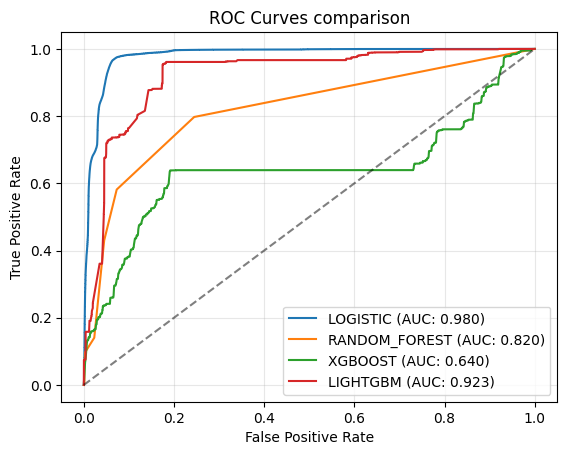

In [ ]:
#Comparing ROC Curves
for name, result in results.items():
  fpr,tpr,_ = roc_curve(y_test,result['predictions'])
  plt.plot(fpr, tpr, label=f"{name.upper()} (AUC: {result['auc_score']:.3f})")

plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves comparison')
plt.legend()
plt.grid(True,alpha=0.3)

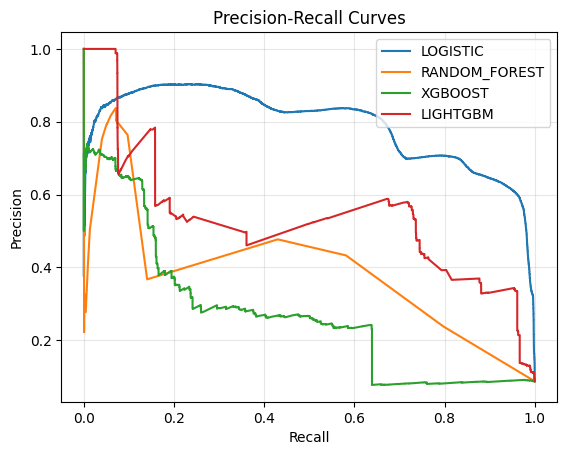

In [ ]:
#Precision-recall curve
for name,result in results.items():
  precision,recall,_ = precision_recall_curve(y_test,result['predictions'])
  plt.plot(recall,precision,label=f"{name.upper()}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curves")
plt.legend(loc='upper right')
plt.grid(True,alpha=0.3)

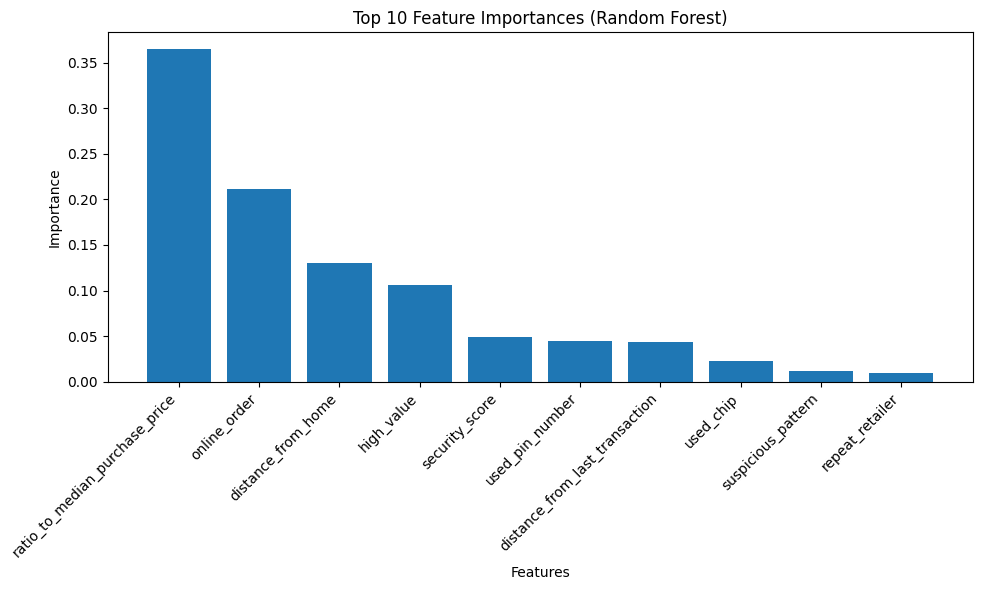

In [ ]:
#Feature importance for random forest
if 'random_forest' in models:
            feature_names = [col for col in df.columns if col != 'fraud']
            importances = models['random_forest'].feature_importances_
            indices = np.argsort(importances)[::-1][:10]

            plt.figure(figsize=(10, 6)) # Added figure size for better visualization
            plt.bar(range(len(indices)), importances[indices])
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title('Top 10 Feature Importances (Random Forest)')
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right') # Corrected xticklabels
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()

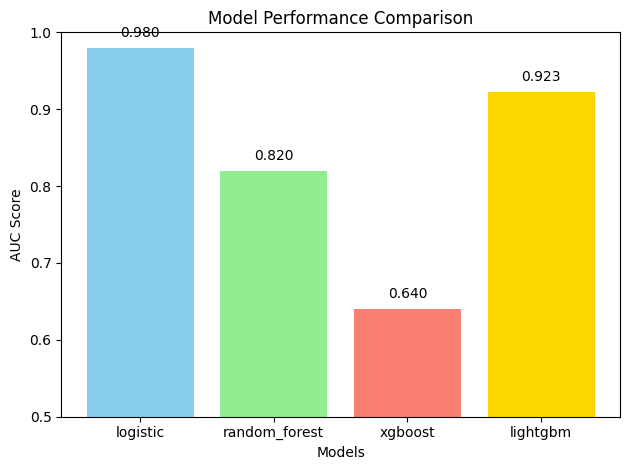

In [ ]:
#Comparing model performances
model_names = list(results.keys())
auc_scores = [results[name]['auc_score'] for name in model_names]

colors = ['skyblue','lightgreen','salmon','gold']
bars = plt.bar(model_names,auc_scores,color=colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.5,1.0)
for bar, score in zip(bars, auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
#Choosing the best model
best_model = max(results.keys(),key = lambda x: results[x]['auc_score'])
print(f"\n Best Model: {best_model} (AUC: {results[best_model]['auc_score']:.4f})")


 Best Model: logistic (AUC: 0.9801)


Logistic Regression is the best model with an AUC score of 0.9801

###Creating AML Monitoring System

In [ ]:
#Assign the best model
model = models[best_model]

In [ ]:
#Calculating the risk_scores for test set
risk_scores = model.predict_proba(X_test)[:,1]

#Assigning risk threshholds
risk_thresholds = {'low':0.3,'medium':0.7,'high':0.9}

In [ ]:
#Creating the monitoring dashboard data
monitoring_data = pd.DataFrame({
    'transaction_id': range(len(risk_scores)),
    'risk_score': risk_scores,
    'actual_fraud': y_test.values,
    'risk_level': pd.cut(risk_scores,
                         bins=[0,risk_thresholds['low'],
                               risk_thresholds['medium'],
                               risk_thresholds['high'],1],
                         labels=['Low','Medium','High','Critical'])
})

In [ ]:
#Creating an AML rules engine
def apply_aml_rules(row):
  rules_triggered = []

  if row['risk_score'] > risk_thresholds['high']:
    rules_triggered.append('HIGH RISK SCORE')

  if row['risk_level'] == 'Critical':
    rules_triggered.append('CRITICAL RISK LEVEL')

  return '|'.join(rules_triggered) if rules_triggered else 'NO ALERT'

monitoring_data['aml_alerts'] = monitoring_data.apply(apply_aml_rules,axis=1)

In [ ]:
#Generating monitoring report
print("\n AML Monitoring Report")
print(f"Total Transaction Monitored: {len(monitoring_data)}")
print("\n Risk Level Distribution:")
print(monitoring_data['risk_level'].value_counts())

print("\n AML Alerts Summary:")
alert_summary = monitoring_data['aml_alerts'].value_counts()
print(alert_summary)


 AML Monitoring Report
Total Transaction Monitored: 200000

 Risk Level Distribution:
risk_level
Low         180008
Medium        9578
High          5331
Critical      5083
Name: count, dtype: int64

 AML Alerts Summary:
aml_alerts
NO ALERT                               194917
HIGH RISK SCORE|CRITICAL RISK LEVEL      5083
Name: count, dtype: int64


In [ ]:
#Detect High risk transactions requiring manual review
high_risk_transactions = monitoring_data[monitoring_data['risk_score']>risk_thresholds['high']]
print(f"\n Transactions requiring manual review: {len(high_risk_transactions)}")


 Transactions requiring manual review: 5083


In [ ]:
#Performance metrics for monitoring system
true_positives = len(monitoring_data[(monitoring_data['risk_score'] > risk_thresholds['medium']) &
                                 (monitoring_data['actual_fraud'] == 1)])
false_positives = len(monitoring_data[(monitoring_data['risk_score'] > risk_thresholds['medium']) &
                                     (monitoring_data['actual_fraud'] == 1)])

precision = true_positives / (true_positives + false_positives)

In [ ]:
print("\n Monitoring System Performance")
print(f"Alert Precision: {precision: .3f}")
print(f"Detection Rate: {true_positives / monitoring_data['actual_fraud'].sum():.3f}")


 Monitoring System Performance
Alert Precision:  0.500
Detection Rate: 0.494


In [ ]:
monitoring_data

,transaction_id,risk_score,actual_fraud,risk_level,aml_alerts
0,0,1.283220e-02,0.0,Low,NO ALERT
1,1,3.085310e-01,1.0,Medium,NO ALERT
2,2,1.066827e-02,0.0,Low,NO ALERT
3,3,9.971473e-01,0.0,Critical,HIGH RISK SCORE|CRITICAL RISK LEVEL
4,4,4.804977e-04,0.0,Low,NO ALERT
...,...,...,...,...,...
199995,199995,2.958453e-06,0.0,Low,NO ALERT
199996,199996,1.392425e-02,0.0,Low,NO ALERT
199997,199997,2.699071e-03,0.0,Low,NO ALERT
199998,199998,2.962516e-05,0.0,Low,NO ALERT


In [ ]:
monitoring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   transaction_id  200000 non-null  int64   
 1   risk_score      200000 non-null  float64 
 2   actual_fraud    200000 non-null  float64 
 3   risk_level      200000 non-null  category
 4   aml_alerts      200000 non-null  object  
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 6.3+ MB
